# Practical 2: Convolutional Networks


## Introduction
In this practical we will cover the basics of convolutional neural networks, or "ConvNets". ConvNets were invented in the late 1980s/early 1990s, and have had tremendous success especially with vision (although they have also been used very successfully in speech processing pipelines, and more recently, for machine translation).

## Learning Objectives
* Be able to explain what a convolutional layer does and how it's different from a fully-connected layer 
* Understand  the assumptions and trade-offs that are being made when using convolutional architectures
* Be able to build a convolutional architecture using Tensorflow and Keras Layers
* Be able to use Keras to train a model on a dataset
* Implement either batch normalisation or a very small residual network

## Running on GPU
For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelelator" box. This is all you need to do, Colab and Tensorflow will take care of the rest! 

In [0]:
#@title Imports (RUN ME!) { display-mode: "form" }

# TODO: Swallow output
!pip -q install pydot_ng
!pip -q install graphviz
!apt install graphviz > /dev/null

from __future__ import absolute_import, division, print_function

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

try:
  tf.enable_eager_execution()
  print('Running in Eager mode.')
except ValueError:
  print('Already running in Eager mode')



Already running in Eager mode


## Convolutional Architectures
When modelling an image using a regular feed-forward network, we find that the number of model parameters grows exponentially. For example, the tiny network we built in Practical 1 already had over 100,000 parameters!

**QUESTION**: How many parameters would there be in a feed-forward network with 2 hidden layers consisting of 512 and 256 neurons respectively, an output size of 10 and an input image of shape [32, 32, 3]? (Note that we represent each pixel in a a colour image using three real-numbers for the Red, Green and Blue values -- [called "channels"](https://www.quora.com/What-do-channels-refer-to-in-a-convolutional-neural-network) -- and hence the 32x32**x3** shape.)

ConvNets address this model parameter issue by exploiting structure in the inputs to the network (in particular, by making the assumption that the input is a 3-D *volume*, which applies to images for example, where the 3 dimensions consist of the three RGB channels). The two key differences between a ConvNet and a Feed-forward network are:

* ConvNets have neurons that are arranged in 3 dimensions: width, height, depth. Note that *depth* here means channels, i.e. the depth of the input volume, not the depth of a deep neural network!
* The neurons in each layer are only connected to a small region of the layer before it.

**QUESTION**: Unfortunately there is no such thing as a free lunch. What trade-off do you think a ConvNet makes for the reduction in memory required by fewer parameters?

Generally a ConvNet architecture is made up of different types of layers, the most common being convolutional layers, pooling layers and fully-connected layers that we encountered in the last practical.

### Aside: The rise of deep convolutional architectures

ConvNet architectures were key to the tremendous success of deep learning in machine vision. In particular, the first deep learning model to win the ImageNet competition in 2012 was called AlexNet (after Alex Krizhevsky, one of its inventors). It had 5 convolutional layers followed by 3 fully-connected layers. Later winners included GoogLeNet and ResNet. If you're curious, have a look at [this link](https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba) for a great summary of different ConvNet architectures.

### Convolutional Layers

A convolutional layer maps an input *volume* (meaning, a 3-D input tensor, e.g. [width, height, channels]) to an output volume through a set of learnable filters, which make up the parameters of the layer. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. (Eg: A filter in the first layer of a ConvNet might have size [5, 5, 3]). During the forward pass, we convolve ("slide") each filter across the width and height of the input volume and compute element-wise dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Each convolutional layer will have such a set of filters, and each of them will produce a separate 2-dimensional activation map. We then stack these activation maps along the depth-dimension to produce the output volume.

By using these filters which map to a small sub-volume of the input, we can to a large extent,control the parameter explosion that we would get with a (fully-connected) feed-forward network. This **parameter sharing** actually also tends to improve the performance of the model on inputs like natural images because it provides the model with some limited **translation invariance**. Translation invariance means that if the image (or a feature in the image) is translated (moved), the model will not be significantly affected. Think about why this is the case!

The following animation illustrates these ideas, make sure you understand them!

![Convolution Animation](https://i.stack.imgur.com/FjvuN.gif)

The hyper-parameters of a convolutional layer are as follows:
* **Filters** defines the number of filters in the layer
* **Kernel Size** defines the width and height of the filters (also called "kernels") in the layer. Note that kernels always have the same depth as the inputs to the layer.
* **Stride** defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
* **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.

Lets look at a very simple, dummy example to see how the values of the hyper-parameters affect the output size of a convolutional layer.

Input shape: (10, 10, 3)


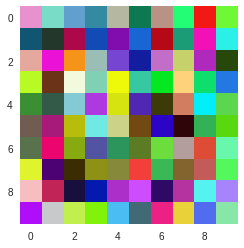

In [0]:
# Create a random colour "image" of shape 10x10 with a depth of 3 (for red, green and blue)
dummy_input = np.random.uniform(size=[10, 10, 3])
fig, ax = plt.subplots(1, 1)
plt.imshow(dummy_input)
ax.grid(False)
print('Input shape: {}'.format(dummy_input.shape))

Now adjust the hyperparameters using the sliders on the right and see how the output shape changes for a [10, 10, 3] input.

In [0]:
#@title Convolutional layer parameters {run: "auto"}
filters = 3  #@param { type: "slider", min:0, max: 10, step: 1 }
kernel_size = 2 #@param { type: "slider", min:1, max: 10, step: 1 }
stride = 1 #@param { type: "slider", min:1, max: 3, step: 1 }

conv_layer = tf.keras.layers.Conv2D(
    filters=filters, 
    kernel_size=kernel_size, 
    strides=stride,
    padding="valid",
    input_shape=[10, 10, 3])

# Convert the image to a tensor and add an extra batch dimension which
# the convolutional layer expects.
input_tensor = tf.convert_to_tensor(dummy_input[None, :, :, :])
convoluted = conv_layer(input_tensor)

print('The output dimension is:')
list([d.value for d in convoluted.shape])[1:]

The output dimension is:


[9, 9, 3]

Note especially how output width and height are related to ```kernel_size``` and ```stride```, and how the output depth is related to ```filters```.

#### Question
Can you come up with a formula for the output shape given the input shape, the hyperparameters of the layer and assuming no padding? 

### (Max) Pooling
A pooling layer reduces the spatial size of the representation. There are different reasons why we may want to do this. One is to reduce the number of parameters in the network. Imagine a convnet for the MNIST dataset. If the feature tensor produced by the final conv/pool/relu layer was say, of size 20x20 and had 100 feature channels, the final dense layer would have 20*20*100*10=400k parameters. However if we down-sampled that layer to a 4x4 spatial size, we would have only 20k parameters. A big difference!

Another reason is that we want later features (deeper int he network) to have larger *receptive fields* (input regions that they look at), in order to represent bigger objects and object parts for instance. In particular, pooling stride gives later features much larger receptive fields so that they can effectively combine smaller features together.

A pooling layer has no trainable parameters itself. It applies some 2-D aggegation operation (usually a max(), but others like average() may also be used) to regions of the input volume. This is done independently for each depth dimension of the input. For example, a 2x2 max pooling operation with a stride of 2, downsamples every depth slice of the input by 2 along both the width and height.

#### Question
Do 2x2 max-pooling by hand, with a stride of 2, on the following 2D input. What is the size of the output?

\begin{bmatrix}
  9 & 5 & 4 & 5 & 6 & 4 \\
  6 & 6 & 3 & 5 & 8 & 2 \\
  4 & 6 & 9 & 1 & 3 & 6 \\
  9 & 7 & 1 & 5 & 8 & 1 \\
  4 & 9 & 9 & 5 & 7 & 3 \\
  7 & 3 & 6 & 4 & 9 & 1 
\end{bmatrix}


Reveal the cell below by double-clicking and running it, to check your answer when you're done!

In [0]:
#@title Answer { display-mode: "form" }
X = np.array([[9, 5, 4, 5, 6, 4],
              [6, 6, 3, 5, 8, 2],
              [4, 6, 9, 1, 3, 6],
              [9, 7, 1, 5, 8, 1],
              [4, 9, 9, 5, 7, 3],
              [7, 3, 6, 4, 9, 1]])

max_pool_layer = tf.keras.layers.MaxPooling2D((2, 2), strides=2)
max_pool_layer(tf.convert_to_tensor(X[None, :, :, None])).numpy().squeeze()


## The CIFAR10 Dataset
Now that we understand convolutional, max-pooling and feed-forward layers, we can combine these as building block to build a ConvNet classifier for images. For this practical, we will use the colour image dataset CIFAR10 (pronounced "seefar ten") which consists of 50,000 training images and 10,000 test images. As we did in Practical 1, we take 10,000 images from the training set to form a validation set and visualise some example images.

In [0]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170508288/170498071 [==============================] - 28s 0us/step


In [0]:
# Take the last 10000 images from the training set to form a validation set 
train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

What are the shapes and data-types of train_images and train_labels?

In [0]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


### Visualise examples from the dataset
Run the cell below multiple times to see various images. (They might look a bit blurry because we've blown up the small images.)

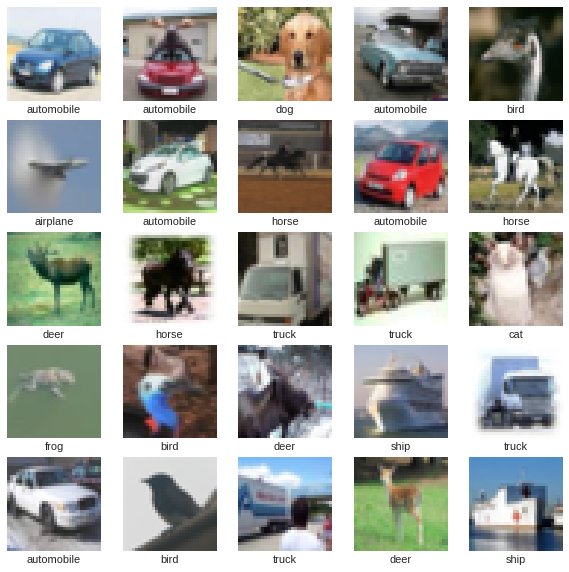

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

## A ConvNet Classifier
Finally, we build a simple convolutional architecture to classify the CIFAR images. We will build a mini version of the AlexNet architecture, which consists of 5 convolutional layers with max-pooling, followed by 3 fully-connected layers at the end. In order to investigate the effect each of these two layers have on the number of parameters, we'll build the model in two stages. 

First, the convolutional layers + max-pooling:

In [0]:
# Define the convolutinal part of the model architecture using Keras Layers.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])


How many parameters are there in the convolutional part of the architecture? We can easily inspect this using the model summary function in Keras:

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 128)         221312    
__________

Now we add a fully-connected part. Note that we also add "Dropout" after the first fully-connected layer. Dropout is a regularization technique which randomly zeros out ("drops") connections between neurons, and it was one of the key innovations of the AlexNet paper in 2012.

In [0]:
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 128)         221312    
__________

### Aside: Random initialization schemes

You might have wondered what values we are using for the initial values of the weights and biases in our model. The short answer is that we typically use random initialization. In this case, we have just been using the default keras initializers for each layer, which are usually sufficient.

The longer answer is that just using completely random numbers does not always work best in practice and that there are a number of common initialization schemes (which are available in most deep learning frameworks such as TensorFlow and Keras).

Lets consider a few examples:

 * When using the ReLU activation it is common to initialize the biases with small positive numbers because this encourages the ReLU activations to start off in the _on_ state, which helps to counteract the _dying ReLU problem_.

 * The deeper neural networks become the more likely it is that gradients will either shrink to the point that they vanish, or grow to the point that they overflow (the _vanishing_ and _exploding_ gradients problems). To help combat this we can initialize our weights to have a (model-specific) appropriate scale. One method for doing this is called [_Xavier_ or _Glorot_](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialization.

 * The _Xavier_ initialization scheme was designed with the _traditional_ activations Sigmoid and TanH in mind, and does not work as well for ReLU activations. An alternative is [_He_](https://arxiv.org/pdf/1502.01852.pdf) initialization which is a modification of _Xavier_ initialization for ReLU activations.

 [This blog](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) goes into more detail on _He_ and _Xavier_ initialization. [The Keras documentation](https://keras.io/initializers/) lists a number of common schemes. 

###Visualizing the model

Let's build a flow-diagram of the model we've constructed to see how information flows between the different layers.

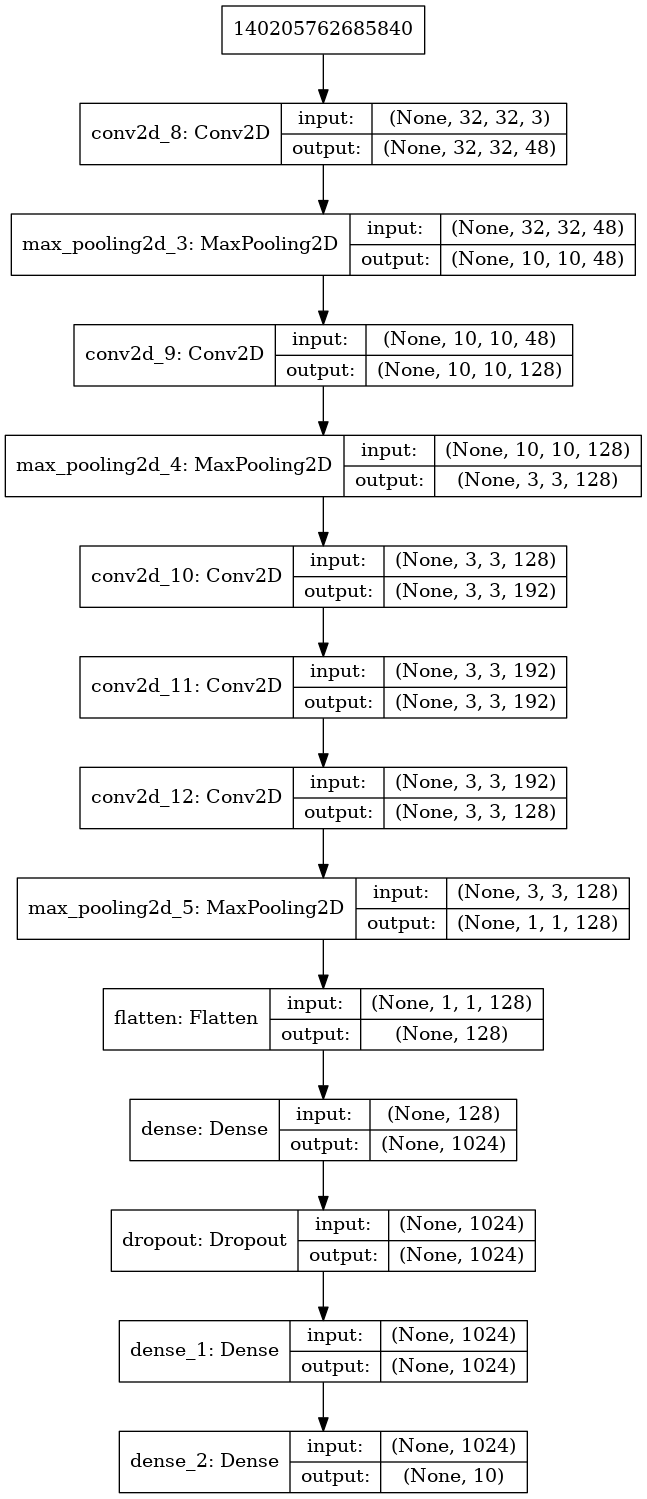

In [0]:
tf.keras.utils.plot_model(model, to_file='small_lenet.png', show_shapes=True, show_layer_names=True)
display.display(display.Image('small_lenet.png'))


### Training and Validating the model
In the last practical we wrote out the dataset pipeline, loss function and training-loop to give you a good appreciation for how it works. This time, we use the training loop built-in to Keras. For simple, standard datasets like CIFAR, doing it this way will work fine, but it's important to know what goes on under the hood because you may need to write some or all of the steps out manually when working with more complex datasets! 

In [0]:
batch_size = 128
num_epochs = 10  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
model.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 10s 253us/step - loss: 1.7632 - acc: 0.3672 - val_loss: 1.4033 - val_acc: 0.4961
Epoch 2/10
40000/40000 [==============================] - 8s 205us/step - loss: 1.3070 - acc: 0.5322 - val_loss: 1.1878 - val_acc: 0.5769
Epoch 3/10
40000/40000 [==============================] - 8s 205us/step - loss: 1.1475 - acc: 0.5962 - val_loss: 1.1151 - val_acc: 0.6132
Epoch 4/10
40000/40000 [==============================] - 8s 204us/step - loss: 1.0261 - acc: 0.6404 - val_loss: 1.0382 - val_acc: 0.6371
Epoch 5/10
40000/40000 [==============================] - 8s 206us/step - loss: 0.9312 - acc: 0.6792 - val_loss: 1.1219 - val_acc: 0.6262
Epoch 6/10
40000/40000 [==============================] - 8s 204us/step - loss: 0.8550 - acc: 0.7039 - val_loss: 1.0031 - val_acc: 0.6547
Epoch 7/10
40000/40000 [==============================] - 9s 213us/step - loss: 0.7825 - acc: 0.7285 - val_loss: 0.9751 -

### Test performance
Finally, we evaluate how well the model does on the held-out test-set

In [0]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

10000/10000 [==============================] - 2s 170us/step
Final TEST performance
loss: 1.03090104685
acc: 0.6695


Note that we achieved roughly 80% training set accuracy, but our test accuracy is only around 67%. What do you think may be the reason for this?

### Classifying examples
We now use our trained model to classify a sample of 25 images from the test set. We pass these 25 images to the  ```model.predict``` function, which returns a [25, 10] dimensional matrix. The entry at position $(i, j)$ of this matrix contains the probability that image $i$ belongs to class $j$. We obtain the most-likely prediction using the ```np.argmax``` function which returns the index of the maximum entry along the columns. Finally, we plot the result with the prediction and prediction probability labelled underneath the image and true label on the side. 

In [0]:
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

predictions = model.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

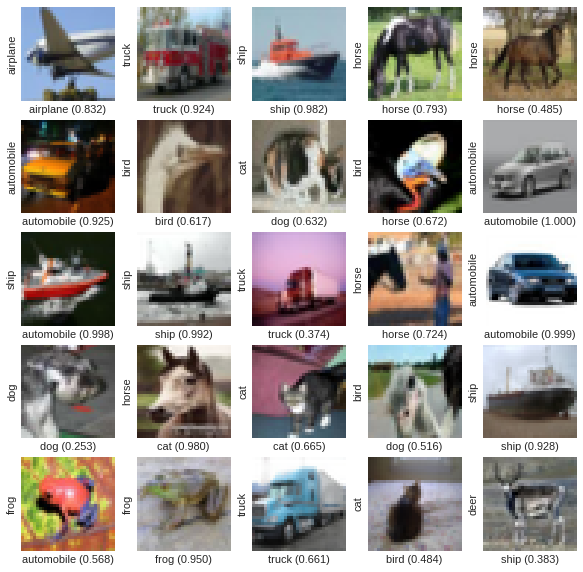

In [0]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))
  

### Question
What do you think of the model's predictions? Looking at the model's confidence (the probability assigned to the predicted class), look for examples of the following cases:
1. The model was correct with high confidence
2. The model was correct with low confidence
3. The model was incorrect with high confidence
4. The model was incorrect with low confidence

What do you think the (relative) loss values would be in those cases? 


### Aside: Uncertainty in deep learning

Deep neural networks are not considered to be very good at estimating the uncertainty in their predictions. However, knowing your model's uncertainty can be very important for many applications. For example, consider a deep learning tool for diagnosing diseases, in this case a false negative could have massive impacts on a person's life! We would really like to know how confident our model is in its prediction. This is a budding field of research, for example see [this blog](https://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html) for a nice introduction.

### Aside: CNN architectures

Deciding on the architecture for a CNN, i.e. the combination of convolution, pooling, dense, and other layers, can be tricky and often can seem arbitrary. On top of that, one also has to make decisions such as what kind of pooling, which activation functions, and what size of convolution to use, among other things. For new and old practitioners of deep learning, these choices can be overwhelming. 

However, by examining existing successful CNN architectures we can learn a lot about what works and what doesn't. (We can even apply these existing architectures to our problems since many deep learning libraries, such as TensorFlow and Keras, have them [built in](https://keras.io/applications/#available-models) and it is even possible to fine-tune pre-trained models to our specific problem using [transfer learning](https://cs231n.github.io/transfer-learning/).)

[This article](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) describes many of the most successful CNN architectures in recent years, including [ResNet](https://arxiv.org/abs/1512.03385), [Inception](https://arxiv.org/pdf/1512.00567v3.pdf) and [VGG](https://arxiv.org/pdf/1409.1556.pdf). For a more detailed and technical description of these models and more see [these slides](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture9.pdf). Reading through these resources should give you insights into why these architectures are successful as well as best practices and current trends for CNNs that will help you design your own architectures.

For example, one of the practices you might pick up on is the use of 3x3 convolutions. You'll notices that older architectures such as [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) used a range of convolutions from 7x7 down to 3x3. However, newer architectures such as VGG and ResNet use 3x3 convolutions almost exclusively. In short, the reason is that stacking 3x3 convolutions gives you the same receptive field as a larger convolution but with more non-linearity. 

Here are some other questions you may want to think about while investigating these architectures:

* Why do modern architectures use less max-pooling?
* What does a 1x1 convolution do?
* What is a residual connection?

## Your Tasks
1. [**ALL**] Experiment with the network architecture, try changing the numbers, types and sizes of layers, the sizes of filters, using different padding etc. How do these decisions affect the performance of the model? In particular, try building a *fully convolutinoal* network, with no (max-)pooling layers. 
2. [**ALL**] Implement BATCH NORMALISATION ([Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) and [research paper](http://proceedings.mlr.press/v37/ioffe15.pdf)) to improve the model's generalisation.
3. [**ADVANCED**] Read about Residual networks ([original paper](https://arxiv.org/pdf/1512.03385.pdf), ) and add **shortcut connections** to the model architecture. Try to build a simple reusable "residual block" as a [Keras Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model). 
4. [**OPTIONAL**]. Visualise the filters of the convolutional layers using Matplotlib. **HINT**: You can retrieve a reference to an indivual layer from the sequential Keras model by calling```model.get_layer(name)```, replacing "name" with the name of the layer. 

##Additional Resources

Here's some more information on ConvNets:

* Chris Colah's blog post on [Understanding Convolutions](https://colah.github.io/posts/2014-07-Understanding-Convolutions/)
* [How do convolutional neural networks work?](http://brohrer.github.io/how_convolutional_neural_networks_work.html)
* The [CS231n course](https://cs231n.github.io/)
* [Building blocks of interpretability](https://distill.pub/2018/building-blocks/)

